In [155]:
# Distributionally Robust End-to-End Portfolio Construction
# Experiment 1 - General
####################################################################################################
# Import libraries
####################################################################################################
import torch
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.close("all")

# Make the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import E2E_DRO functions
from e2edro import e2edro as e2e
from e2edro import DataLoad as dl
from e2edro import BaseModels as bm
from e2edro import PlotFunctions as pf

# Path to cache the data, models and results
cache_path = "./cache/exp/"
# cache_path = "C:\\Users\\Rafay\Documents\\thesis\\ActualWork\\Backtester\\E2E-DRO\\cache\\exp\\"
####################################################################################################
# Experiments 1-4 (with hisotrical data): Load data
####################################################################################################

# Data frequency and start/end dates
freq = 'weekly'
start = '2000-01-01'
end = '2021-09-30'

# Train, validation and test split percentage
split = [0.6, 0.4]

# Number of observations per window 
n_obs = 104

# Number of assets
n_y = 20

# AlphaVantage API Key. 
# Note: User API keys can be obtained for free from www.alphavantage.co. Users will need a free 
# academic or paid license to download adjusted closing pricing data from AlphaVantage.
AV_key = 'W5ACAYR6PEX7L28T'

# Historical data: Download data (or load cached data)
X, Y = dl.AV(start, end, split, freq=freq, n_obs=n_obs, n_y=n_y, use_cache=True,
            save_results=False, AV_key=AV_key)

# Number of features and assets
n_x, n_y = X.data.shape[1], Y.data.shape[1]

####################################################################################################
# E2E Learning System Run
####################################################################################################

#---------------------------------------------------------------------------------------------------
# Initialize parameters
#---------------------------------------------------------------------------------------------------

# Performance loss function and performance period 'v+1'
perf_loss='sharpe_loss'
perf_period = 13

# Weight assigned to MSE prediction loss function
pred_loss_factor = 0.5

# Risk function (default set to variance)
prisk = 'p_var'

# Robust decision layer to use: hellinger or tv
dr_layer = 'hellinger'

# List of learning rates to test
lr_list = [0.005, 0.0125, 0.02]

# List of total no. of epochs to test
epoch_list = [30, 40, 50, 60, 80, 100]

# For replicability, set the random seed for the numerical experiments
set_seed = 1000

# Load saved models (default is False)
use_cache = True

#---------------------------------------------------------------------------------------------------
# Run 
#---------------------------------------------------------------------------------------------------

if use_cache:
    # Load cached models and backtest results
    with open(cache_path+'ew_net.pkl', 'rb') as inp:
        ew_net = pickle.load(inp)
    with open(cache_path+'po_net.pkl', 'rb') as inp:
        po_net = pickle.load(inp)
    with open(cache_path+'base_net.pkl', 'rb') as inp:
        base_net = pickle.load(inp)
    with open(cache_path+'nom_net.pkl', 'rb') as inp:
        nom_net = pickle.load(inp)
    with open(cache_path+'dr_net.pkl', 'rb') as inp:
        dr_net = pickle.load(inp)
    with open(cache_path+'dr_po_net.pkl', 'rb') as inp:
        dr_po_net = pickle.load(inp)
    with open(cache_path+'dr_net_learn_delta.pkl', 'rb') as inp:
        dr_net_learn_delta = pickle.load(inp)
    with open(cache_path+'nom_net_learn_gamma.pkl', 'rb') as inp:
        nom_net_learn_gamma = pickle.load(inp)
    with open(cache_path+'dr_net_learn_gamma.pkl', 'rb') as inp:
        dr_net_learn_gamma = pickle.load(inp)
    with open(cache_path+'dr_net_learn_gamma_delta.pkl', 'rb') as inp:
        dr_net_learn_gamma_delta = pickle.load(inp)
    with open(cache_path+'nom_net_learn_theta.pkl', 'rb') as inp:
        nom_net_learn_theta = pickle.load(inp)
    with open(cache_path+'dr_net_learn_theta.pkl', 'rb') as inp:
        dr_net_learn_theta = pickle.load(inp)

    with open(cache_path+'base_net_ext.pkl', 'rb') as inp:
        base_net_ext = pickle.load(inp)
    with open(cache_path+'nom_net_ext.pkl', 'rb') as inp:
        nom_net_ext = pickle.load(inp)
    with open(cache_path+'dr_net_ext.pkl', 'rb') as inp:
        dr_net_ext = pickle.load(inp)
    with open(cache_path+'dr_net_learn_delta_ext.pkl', 'rb') as inp:
        dr_net_learn_delta_ext = pickle.load(inp)
    with open(cache_path+'nom_net_learn_gamma_ext.pkl', 'rb') as inp:
        nom_net_learn_gamma_ext = pickle.load(inp)
    with open(cache_path+'dr_net_learn_gamma_ext.pkl', 'rb') as inp:
        dr_net_learn_gamma_ext = pickle.load(inp)
    with open(cache_path+'nom_net_learn_theta_ext.pkl', 'rb') as inp:
        nom_net_learn_theta_ext = pickle.load(inp)
    with open(cache_path+'dr_net_learn_theta_ext.pkl', 'rb') as inp:
        dr_net_learn_theta_ext = pickle.load(inp)

    with open(cache_path+'dr_net_tv.pkl', 'rb') as inp:
        dr_net_tv = pickle.load(inp)
    with open(cache_path+'dr_net_tv_learn_delta.pkl', 'rb') as inp:
        dr_net_tv_learn_delta = pickle.load(inp)
    with open(cache_path+'dr_net_tv_learn_gamma.pkl', 'rb') as inp:
        dr_net_tv_learn_gamma = pickle.load(inp)
    with open(cache_path+'dr_net_tv_learn_theta.pkl', 'rb') as inp:
        dr_net_tv_learn_theta = pickle.load(inp)
else:
    # Exp 1: Equal weight portfolio
    ew_net = bm.equal_weight(n_x, n_y, n_obs)
    ew_net.net_roll_test(X, Y, n_roll=4)
    with open(cache_path+'ew_net.pkl', 'wb') as outp:
            pickle.dump(ew_net, outp, pickle.HIGHEST_PROTOCOL)
    print('ew_net run complete')

    # Exp 1, 2, 3: Predict-then-optimize system
    po_net = bm.pred_then_opt(n_x, n_y, n_obs, set_seed=set_seed, prisk=prisk).double()
    po_net.net_roll_test(X, Y)
    with open(cache_path+'po_net.pkl', 'wb') as outp:
        pickle.dump(po_net, outp, pickle.HIGHEST_PROTOCOL)
    print('po_net run complete')

    # Exp 1: Base E2E
    base_net = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=False, train_delta=False,
                        set_seed=set_seed, opt_layer='base_mod', perf_loss=perf_loss, 
                        perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    base_net.net_cv(X, Y, lr_list, epoch_list)
    base_net.net_roll_test(X, Y)
    with open(cache_path+'base_net.pkl', 'wb') as outp:
        pickle.dump(base_net, outp, pickle.HIGHEST_PROTOCOL)
    print('base_net run complete')

    # Exp 1: Nominal E2E
    nom_net = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=True, train_delta=False,
                        set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    nom_net.net_cv(X, Y, lr_list, epoch_list)
    nom_net.net_roll_test(X, Y)
    with open(cache_path+'nom_net.pkl', 'wb') as outp:
        pickle.dump(nom_net, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net run complete')

    # Exp 1: DR E2E
    dr_net = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=True, train_delta=True,
                        set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    dr_net.net_cv(X, Y, lr_list, epoch_list)
    dr_net.net_roll_test(X, Y)
    with open(cache_path+'dr_net.pkl', 'wb') as outp:
        pickle.dump(dr_net, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net run complete')

    # Exp 2: DR predict-then-optimize system
    dr_po_net = bm.pred_then_opt(n_x, n_y, n_obs, set_seed=set_seed, prisk=prisk,
                                opt_layer=dr_layer).double()
    dr_po_net.net_roll_test(X, Y)
    with open(cache_path+'dr_po_net.pkl', 'wb') as outp:
        pickle.dump(dr_po_net, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_po_net run complete')

    # Exp 2: DR E2E (fixed theta and gamma, learn delta)
    dr_net_learn_delta = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=False, train_gamma=False, train_delta=True,
                        set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    dr_net_learn_delta.net_cv(X, Y, lr_list, epoch_list)
    dr_net_learn_delta.net_roll_test(X, Y)
    with open(cache_path+'dr_net_learn_delta.pkl', 'wb') as outp:
        pickle.dump(dr_net_learn_delta, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_learn_delta run complete')

    # Exp 3: Nominal E2E (fixed theta, learn gamma)
    nom_net_learn_gamma = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=False, train_gamma=True, train_delta=False,
                        set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    nom_net_learn_gamma.net_cv(X, Y, lr_list, epoch_list)
    nom_net_learn_gamma.net_roll_test(X, Y)
    with open(cache_path+'nom_net_learn_gamma.pkl', 'wb') as outp:
        pickle.dump(nom_net_learn_gamma, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_learn_gamma run complete')

    # Exp 3: DR E2E (fixed theta, learn gamma, fixed delta)
    dr_net_learn_gamma = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=False, train_gamma=True, train_delta=False,
                        set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    dr_net_learn_gamma.net_cv(X, Y, lr_list, epoch_list)
    dr_net_learn_gamma.net_roll_test(X, Y)
    with open(cache_path+'dr_net_learn_gamma.pkl', 'wb') as outp:
        pickle.dump(dr_net_learn_gamma, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_learn_gamma run complete')

    # Exp 4: Nominal E2E (learn theta, fixed gamma)
    nom_net_learn_theta = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=False, train_delta=False,
                        set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    nom_net_learn_theta.net_cv(X, Y, lr_list, epoch_list)
    nom_net_learn_theta.net_roll_test(X, Y)
    with open(cache_path+'nom_net_learn_theta.pkl', 'wb') as outp:
        pickle.dump(nom_net_learn_theta, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_learn_theta run complete')

    # Exp 4: DR E2E (learn theta, fixed gamma and delta)
    dr_net_learn_theta = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=False, train_delta=False,
                        set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    dr_net_learn_theta.net_cv(X, Y, lr_list, epoch_list)
    dr_net_learn_theta.net_roll_test(X, Y)
    with open(cache_path+'dr_net_learn_theta.pkl', 'wb') as outp:
        pickle.dump(dr_net_learn_theta, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_learn_theta run complete')

####################################################################################################
# Merge objects with their extended-epoch counterparts
####################################################################################################
if use_cache:
    portfolios = ["base_net", "nom_net", "dr_net", "dr_net_learn_delta", "nom_net_learn_gamma",
                "dr_net_learn_gamma", "nom_net_learn_theta", "dr_net_learn_theta"]
    
    for portfolio in portfolios: 
        cv_combo = pd.concat([eval(portfolio).cv_results, eval(portfolio+'_ext').cv_results], 
                        ignore_index=True)
        eval(portfolio).load_cv_results(cv_combo)
        if eval(portfolio).epochs > 50:
            exec(portfolio + '=' + portfolio+'_ext')
            eval(portfolio).load_cv_results(cv_combo)

####################################################################################################
# Numerical results
####################################################################################################

#---------------------------------------------------------------------------------------------------
# Experiment 1: General
#---------------------------------------------------------------------------------------------------

# Validation results table
dr_net.cv_results = dr_net.cv_results.sort_values(['epochs', 'lr'], ascending=[True, 
                                                                    True]).reset_index(drop=True)
exp1_validation_table = pd.concat((base_net.cv_results.round(4), 
                            nom_net.cv_results.val_loss.round(4), 
                            dr_net.cv_results.val_loss.round(4)), axis=1)
exp1_validation_table.set_axis(['eta', 'Epochs', 'Base', 'Nom.', 'DR'], 
                        axis=1, inplace=True) 

# Out-of-sample summary statistics table
portfolios = ["ew_net", "po_net", "base_net", "nom_net", "dr_net"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp1_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['EW', 'PO', 'Base', 
                                                                    'Nom.', 'DR'])
exp1_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True)

# Wealth evolution plot
plt.rcParams['text.usetex'] = True
portfolio_names = [r'EW', r'PO', r'Base', r'Nominal', r'DR']
portfolio_list = [ew_net.portfolio, po_net.portfolio, base_net.portfolio, nom_net.portfolio,
                dr_net.portfolio]
portfolio_colors = ["dimgray", "forestgreen", "goldenrod", "dodgerblue", "salmon"]

pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_exp1.pdf")
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_exp1.pdf")

# List of initial parameters
exp1_param_dict = dict({'po_net':po_net.gamma.item(),
                'nom_net':nom_net.gamma_init,
                'dr_net':[dr_net.gamma_init, dr_net.delta_init]})

# Trained values for each out-of-sample investment period
exp1_trained_vals = pd.DataFrame(zip([nom_net.gamma_init]+nom_net.gamma_trained, 
                                    [dr_net.gamma_init]+dr_net.gamma_trained, 
                                    [dr_net.delta_init]+dr_net.delta_trained), 
                                    columns=[r'Nom. $\gamma$', r'DR $\gamma$', r'DR $\delta$'])

#---------------------------------------------------------------------------------------------------
# Experiment 2: Learn delta
#---------------------------------------------------------------------------------------------------

# Validation results table
dr_net_learn_delta.cv_results = dr_net_learn_delta.cv_results.sort_values(['epochs', 'lr'],
                                                    ascending=[True, True]).reset_index(drop=True)
exp2_validation_table = dr_net_learn_delta.cv_results.round(4)
exp2_validation_table.set_axis(['eta', 'Epochs', 'DR (learn delta)'], axis=1, inplace=True) 

# Out-of-sample summary statistics table
portfolios = ["po_net", "dr_po_net", "dr_net_learn_delta"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp2_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['PO','DR','DR (learn delta)'])
exp2_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True) 

# Wealth evolution plots
plt.rcParams['text.usetex'] = True
portfolio_names = [r'PO', r'DR', r'DR (learn $\delta$)']
portfolio_list = [po_net.portfolio, dr_po_net.portfolio, dr_net_learn_delta.portfolio]
portfolio_colors = ["forestgreen", "dodgerblue", "salmon"]

pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_exp2.pdf")
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_exp2.pdf")

# List of initial parameters
exp2_param_dict = dict({'po_net':po_net.gamma.item(),
                'dr_po_net':[dr_po_net.gamma.item(), dr_po_net.delta.item()],
                'dr_net_learn_delta':[dr_net_learn_delta.gamma_init,dr_net_learn_delta.delta_init]})

# Trained values for each out-of-sample investment period
exp2_trained_vals = pd.DataFrame([dr_net_learn_delta.delta_init]+dr_net_learn_delta.delta_trained,
                                columns=['DR delta'])

#---------------------------------------------------------------------------------------------------
# Experiment 3: Learn gamma
#---------------------------------------------------------------------------------------------------

# Validation results table
dr_net_learn_gamma.cv_results = dr_net_learn_gamma.cv_results.sort_values(['epochs', 'lr'], 
                                                    ascending=[True, True]).reset_index(drop=True)
dr_net_learn_gamma_delta.cv_results = dr_net_learn_gamma_delta.cv_results.sort_values(['epochs',
                                            'lr'], ascending=[True, True]).reset_index(drop=True)
exp3_validation_table = pd.concat((nom_net_learn_gamma.cv_results.round(4), 
                            dr_net_learn_gamma.cv_results.val_loss.round(4),
                            dr_net_learn_gamma_delta.cv_results.val_loss.round(4)), axis=1)
exp3_validation_table.set_axis(['eta', 'Epochs', 'Nom. (learn gamma)', 'DR (learn gamma)', 
                                'DR (learn gamma + delta)'], axis=1, inplace=True) 

# Out-of-sample summary statistics table
# portfolios = ["po_net", "nom_net_learn_gamma", "dr_net_learn_gamma", "dr_net_learn_gamma_delta"]
portfolios = ["po_net", "nom_net_learn_gamma", "dr_net_learn_gamma"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp3_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['PO', 'Nom. (learn gamma)',
                                                                    'DR (learn gamma)'])
exp3_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True) 

# Wealth evolution plots
# portfolio_names = [r'PO', r'Nominal', r'DR ($\gamma$)', r'DR ($\gamma + \delta$)']
portfolio_names = [r'PO', r'Nominal', r'DR']
portfolio_list = [po_net.portfolio, nom_net_learn_gamma.portfolio, dr_net_learn_gamma.portfolio]
portfolio_colors = ["forestgreen", "dodgerblue", "salmon"]

pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_exp3.pdf")
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_exp3.pdf")

# List of initial parameters
exp3_param_dict = dict({'po_net':po_net.gamma.item(),
            'nom_net_learn_gamma':nom_net_learn_gamma.gamma_init,
            'dr_net_learn_gamma':[dr_net_learn_gamma.gamma_init, dr_net_learn_gamma.delta_init],
            'dr_net_learn_gamma_delta':[dr_net_learn_gamma_delta.gamma_init,
                                        dr_net_learn_gamma_delta.delta_init]})

# Trained values for each out-of-sample investment period
exp3_trained_vals = pd.DataFrame(zip(
                    [nom_net_learn_gamma.gamma_init]+nom_net_learn_gamma.gamma_trained, 
                    [dr_net_learn_gamma.gamma_init]+dr_net_learn_gamma.gamma_trained, 
                    [dr_net_learn_gamma_delta.gamma_init]+dr_net_learn_gamma_delta.gamma_trained,
                    [dr_net_learn_gamma_delta.delta_init]+dr_net_learn_gamma_delta.delta_trained),  
                                    columns=['Nom. gamma', 'DR gamma', 'DR gamma 2', 'DR delta'])

#---------------------------------------------------------------------------------------------------
# Experiment 4: Learn theta
#---------------------------------------------------------------------------------------------------

# Validation results table
dr_net_learn_theta.cv_results = dr_net_learn_theta.cv_results.sort_values(['epochs', 'lr'], 
                                                    ascending=[True, True]).reset_index(drop=True)
exp4_validation_table = pd.concat((base_net.cv_results.round(4), 
                            nom_net_learn_theta.cv_results.val_loss.round(4), 
                            dr_net_learn_theta.cv_results.val_loss.round(4)), axis=1)
exp4_validation_table.set_axis(['eta', 'Epochs', 'Base', 'Nom.', 'DR'], 
                        axis=1, inplace=True) 

# Out-of-sample summary statistics table
portfolios = ["po_net", "base_net", "nom_net_learn_theta", "dr_net_learn_theta"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp4_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['PO', 'Base', 'Nom.', 'DR'])
exp4_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True) 

# Wealth evolution plots
plt.rcParams['text.usetex'] = True
portfolio_names = [r'PO', r'Base', r'Nominal', r'DR']
portfolio_list = [po_net.portfolio, base_net.portfolio, nom_net_learn_theta.portfolio,
                dr_net_learn_theta.portfolio]

portfolio_colors = ["forestgreen", "goldenrod", "dodgerblue", "salmon"]
pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_exp4.pdf")
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_exp4.pdf")

# List of initial parameters
exp4_param_dict = dict({'po_net':po_net.gamma.item(),
                    'nom_net_learn_theta':nom_net_learn_theta.gamma_init,
                    'dr_net_learn_theta':[dr_net_learn_theta.gamma_init, 
                                        dr_net_learn_theta.delta_init]})

# Trained values for each out-of-sample investment period
exp4_trained_vals = pd.DataFrame(zip(nom_net_learn_theta.gamma_trained, 
                                    dr_net_learn_theta.gamma_trained, 
                                    dr_net_learn_theta.delta_trained), 
                                columns=['Nom. gamma', 'DR gamma', 'DR delta'])

#---------------------------------------------------------------------------------------------------
# Aggregate Validation Results
#---------------------------------------------------------------------------------------------------

validation_table = pd.concat((base_net.cv_results.round(4), 
                            nom_net.cv_results.val_loss.round(4),
                            nom_net_learn_gamma.cv_results.val_loss.round(4),
                            nom_net_learn_theta.cv_results.val_loss.round(4), 
                            dr_net.cv_results.val_loss.round(4),
                            dr_net_learn_delta.cv_results.val_loss.round(4),
                            dr_net_learn_gamma.cv_results.val_loss.round(4),
                            dr_net_learn_gamma_delta.cv_results.val_loss.round(4),
                            dr_net_learn_theta.cv_results.val_loss.round(4)), axis=1)
validation_table.set_axis(['eta', 'Epochs', 'Base', 'Nom.', 'Nom. (gamma)', 'Nom. (theta)', 
                        'DR', 'DR (delta)', 'DR (gamma)', 'DR (gamma+delta)', 'DR (theta)'], 
                        axis=1, inplace=True) 

####################################################################################################
# Experiment 5 (with synthetic data)
####################################################################################################

# Path to cache the data, models and results
cache_path_exp5 = "cache/exp5/"

#---------------------------------------------------------------------------------------------------
# Experiment 5: Load data
#---------------------------------------------------------------------------------------------------

# Train, validation and test split percentage
split = [0.7, 0.3]

# Number of feattures and assets
n_x, n_y = 5, 10

# Number of observations per window and total number of observations
n_obs, n_tot = 100, 1200

# Synthetic data: randomly generate data from a linear model
X, Y = dl.synthetic_exp(n_x=n_x, n_y=n_y, n_obs=n_obs, n_tot=n_tot, split=split)

#---------------------------------------------------------------------------------------------------
# Experiment 5: Initialize parameters
#---------------------------------------------------------------------------------------------------

# Performance loss function and performance period 'v+1'
perf_loss='sharpe_loss'
perf_period = 13

# Weight assigned to MSE prediction loss function
pred_loss_factor = 0.5

# Risk function (default set to variance)
prisk = 'p_var'

# Robust decision layer to use: hellinger or tv
dr_layer = 'hellinger'

# Determine whether to train the prediction weights Theta
train_pred = True

# List of learning rates to test
lr_list = [0.005, 0.0125, 0.02]

# List of total no. of epochs to test
epoch_list = [20, 40, 60]

# Load saved models (default is False)
use_cache = True

#---------------------------------------------------------------------------------------------------
# Run 
#---------------------------------------------------------------------------------------------------
if use_cache:
    with open(cache_path_exp5+'nom_net_linear.pkl', 'rb') as inp:
        nom_net_linear = pickle.load(inp)
    with open(cache_path_exp5+'nom_net_2layer.pkl', 'rb') as inp:
        nom_net_2layer = pickle.load(inp)
    with open(cache_path_exp5+'nom_net_3layer.pkl', 'rb') as inp:
        nom_net_3layer = pickle.load(inp)
    with open(cache_path_exp5+'dr_net_linear.pkl', 'rb') as inp:
        dr_net_linear = pickle.load(inp)
    with open(cache_path_exp5+'dr_net_2layer.pkl', 'rb') as inp:
        dr_net_2layer = pickle.load(inp)
    with open(cache_path_exp5+'dr_net_3layer.pkl', 'rb') as inp:
        dr_net_3layer = pickle.load(inp)
else:

    #***********************************************************************************************
    # Linear models
    #***********************************************************************************************
    
    # For replicability, set the random seed for the numerical experiments
    set_seed = 2000

    # Nominal E2E linear
    nom_net_linear = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, 
                    set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    nom_net_linear.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    nom_net_linear.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'nom_net_linear.pkl', 'wb') as outp:
        pickle.dump(nom_net_linear, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_linear run complete')

    # DR E2E linear
    dr_net_linear = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, 
                    set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    dr_net_linear.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    dr_net_linear.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'dr_net_linear.pkl', 'wb') as outp:
        pickle.dump(dr_net_linear, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_linear run complete')

    #***********************************************************************************************
    # 2-layer models
    #***********************************************************************************************

    # For replicability, set the random seed for the numerical experiments
    set_seed = 3000

    # Nominal E2E 2-layer
    nom_net_2layer = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, pred_model='2layer',
                    set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    nom_net_2layer.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    nom_net_2layer.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'nom_net_2layer.pkl', 'wb') as outp:
        pickle.dump(nom_net_2layer, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_2layer run complete')

    # DR E2E 2-layer
    dr_net_2layer = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, pred_model='2layer',
                    set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    dr_net_2layer.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    dr_net_2layer.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'dr_net_2layer.pkl', 'wb') as outp:
        pickle.dump(dr_net_2layer, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_2layer run complete')

    #***********************************************************************************************
    # 3-layer models
    #***********************************************************************************************

    # For replicability, set the random seed for the numerical experiments
    set_seed = 4000

    # Nominal E2E 3-layer
    nom_net_3layer = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, pred_model='3layer',
                    set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    nom_net_3layer.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    nom_net_3layer.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'nom_net_3layer.pkl', 'wb') as outp:
        pickle.dump(nom_net_3layer, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_3layer run complete')

    # DR E2E 3-layer
    dr_net_3layer = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, pred_model='3layer',
                    set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    dr_net_3layer.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    dr_net_3layer.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'dr_net_3layer.pkl', 'wb') as outp:
        pickle.dump(dr_net_3layer, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_3layer run complete')

#---------------------------------------------------------------------------------------------------
# Experiment 5: Results
#---------------------------------------------------------------------------------------------------

# Validation results table
exp5_validation_table = pd.concat((nom_net_linear.cv_results.round(4), 
                            dr_net_linear.cv_results.val_loss.round(4), 
                            nom_net_2layer.cv_results.val_loss.round(4), 
                            dr_net_2layer.cv_results.val_loss.round(4), 
                            nom_net_3layer.cv_results.val_loss.round(4), 
                            dr_net_3layer.cv_results.val_loss.round(4)), axis=1)
exp5_validation_table.set_axis(['eta', 'Epochs', 'Nom. (linear)', 'DR (linear)', 
                            'Nom. (2-layer)', 'DR (2-layer)', 'Nom. (3-layer)', 'DR (3-layer)'],
                            axis=1, inplace=True) 

# Out-of-sample summary statistics table
portfolios = ["nom_net_linear", "dr_net_linear", "nom_net_2layer", 
                "dr_net_2layer", "nom_net_3layer", "dr_net_3layer"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp5_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['Nom. (linear)', 
                'DR (linear)', 'Nom. (2-layer)', 'DR (2-layer)', 'Nom. (3-layer)', 'DR (3-layer)'])
exp5_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True) 

# Wealth evolution plot
plt.rcParams['text.usetex'] = True
portfolio_names = [r'Nom. (linear)', r'DR (linear)', r'Nom. (2-layer)', r'DR (2-layer)', 
                    r'Nom. (3-layer)', r'DR (3-layer)']
portfolio_list = [nom_net_linear.portfolio, dr_net_linear.portfolio, nom_net_2layer.portfolio,
                dr_net_2layer.portfolio, nom_net_3layer.portfolio, dr_net_3layer.portfolio]
portfolio_colors = ["dodgerblue", "salmon", "dodgerblue", "salmon", "dodgerblue", "salmon"]
pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, nplots=3,
                path=cache_path+"plots/wealth_exp5.pdf")

from importlib import reload
reload(pf)

# List of initial parameters
exp5_param_dict = dict({'nom_net_linear':nom_net_linear.gamma_init,
                    'dr_net_linear':[dr_net_linear.gamma_init, dr_net_linear.delta_init],
                    'nom_net_2layer':nom_net_2layer.gamma_init,
                    'dr_net_2layer':[dr_net_2layer.gamma_init, dr_net_2layer.delta_init],
                    'nom_net_3layer':nom_net_3layer.gamma_init,
                    'dr_net_3layer':[dr_net_3layer.gamma_init, dr_net_3layer.delta_init]})
                    

/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:99: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  base_net = pickle.load(inp)
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:99: DeprecationWarning: Please use `coo_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.coo` namespace is deprecated.
  base_net = pickle.load(inp)
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:99: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  base_net = pickle.load(inp)
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:101: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  nom_net = pickle.load(inp)
/var/folders/by/92cslb_x53v6ccmq5w0pl46r

EW
PO
Base
Nominal
DR


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:343: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  exp2_validation_table.set_axis(['eta', 'Epochs', 'DR (learn delta)'], axis=1, inplace=True)
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:360: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  exp2_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True)


PO
DR
DR (learn $\delta$)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:394: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  exp3_validation_table.set_axis(['eta', 'Epochs', 'Nom. (learn gamma)', 'DR (learn gamma)',
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:414: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  exp3_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True)


PO
Nominal
DR


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:452: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  exp4_validation_table.set_axis(['eta', 'Epochs', 'Base', 'Nom.', 'DR'],
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:470: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  exp4_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True)


PO
Base
Nominal
DR


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:509: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  validation_table.set_axis(['eta', 'Epochs', 'Base', 'Nom.', 'Nom. (gamma)', 'Nom. (theta)',
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:570: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  nom_net_linear = pickle.load(inp)
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/2519059060.py:570: DeprecationWarning: Please use `coo_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.coo` namespace is d

Nom. (linear)
DR (linear)
Nom. (2-layer)
DR (2-layer)
Nom. (3-layer)
DR (3-layer)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
# Naive Model Module
#
####################################################################################################
## Import libraries
####################################################################################################
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import e2edro.RiskFunctions as rf
import e2edro.PortfolioClasses as pc
import e2edro.e2edro as e2e


In [ ]:
from scipy.stats import gmean
'''
Inputs: AssetReturns: Pandas DataFrame, each date is a row, one column for each asset
        FactorReturn: Pandas DataFrame, each date is a row, one column for each factor
        Technique: Method through which parameters will be estimated. Default: OLS
Outputs: mu: numpy array, key: Symbol. value: return estimate
         Q: nxn Asset Covariance Matrix (n: # of assets)
'''
def GetParameterEstimates(AssetReturns, FactorReturns, technique='OLS', log=True, bad=False):
    # Only have OLS implemented so far
    if technique!='OLS':
        return [], []
    
    if type(AssetReturns) == pd.core.frame.DataFrame:
        AssetReturns_np = AssetReturns.to_numpy()
        FactorReturns_np = FactorReturns.to_numpy()
    else:
        AssetReturns_np = AssetReturns.cpu().detach().numpy()[0]
        FactorReturns_np = FactorReturns.cpu().detach().numpy()[0][:-1]

    if bad:
        Q = np.cov(AssetReturns_np, rowvar=False)
        mu = 1 - (gmean(1+AssetReturns_np))

        return mu, Q

    T,n = AssetReturns_np.shape
    _, p = FactorReturns_np.shape

    # Get Data Matrix - Factors
    X = np.zeros((T, p+1))
    X[:,:-1] = np.ones((T,1)) # Add ones to first row
    X[:,1:] = FactorReturns_np

    # Get regression coefficients for Assets
    # B = (X^TX)^(-1)X^Ty
    B = np.matmul(np.linalg.inv((np.matmul(np.transpose(X), X))), (np.matmul(np.transpose(X), AssetReturns_np)))

    # Get alpha and betas
    a = np.transpose(B[0,:])
    V = B[1:(p+1),:]

    # Residual Variance to get D
    ep = AssetReturns_np - np.matmul(X, B)
    sigma_ep = 1/(T-p-1) * np.sum(np.square(ep), axis=0)
    D = np.diag(sigma_ep)

    # Get Factor Estimated Return and Covariance Matrix
    f_bar = np.transpose(np.mean(FactorReturns_np, axis=0))
    F = np.cov(FactorReturns_np, rowvar=False)

    # Get mu
    mu = a + np.matmul(np.transpose(V), f_bar)

    # Get Q
    Q = np.matmul(np.matmul(np.transpose(V), F), V) + D

    # Make sure Q is PSD
    w,v = np.linalg.eig(Q)
    min_eig = np.min(w)


    if min_eig<0:
        print('--Not PSD--Adding Min Eigenvalue--')
        Q -= min_eig*np.identity(n)

    if log:
        print("Shape of X: {}".format(X.shape))
        print("Shape of B: {}".format(B.shape))
        print("Shape of X*B: {}".format(np.matmul(X, B).shape))
        print("Shape of ep: {}".format(ep.shape))
        print("Shape of sigma_ep: {}".format(sigma_ep.shape))
        print("Shape of D: {}".format(sigma_ep.shape))
        print("Shape of Q: {}".format(Q.shape))
    
    return mu, Q


In [ ]:
type(Y.train()) == pd.core.frame.DataFrame

True

In [ ]:
mu, Q = GetParameterEstimates(Y.train(), X.train(), log=False, bad=True)
print(Q.shape)

(20, 20)


In [ ]:
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

In [ ]:
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

In [97]:
import numpy as np
import cvxpy as cp
import math

class TraditionalOptimizer:
    """
    """
    def __init__(self, n_x, n_y, n_obs):
        """
        Inputs
        n_x: Number of inputs (i.e., features) in the prediction model
        n_y: Number of outputs from the prediction model
        n_obs: Number of scenarios from which to calculate the sample set of residuals
        """
        self.n_x = n_x
        self.n_y = n_y
        self.n_obs = n_obs

    '''
    Distributionally Robust Risk Parity With Wasserstein Distance Optimizer
    Inputs: mu: numpy array, key: Symbol. value: return estimate
            Q: nxn Asset Covariance Matrix (n: # of assets)
    Outputs: x: optimal allocations

    Formula:
        \min_{\boldsymbol{\phi} \in \mathcal{X}} {(\sqrt{\boldsymbol{\phi}^T \Sigma_{\mathcal{P}}(R)\boldsymbol{\phi}} + \sqrt{\delta}||\boldsymbol{\phi}||_p)^2} - c\sum_{i=1}^n ln(y)

    '''

    def optimize(self,mu,Q):
        raise NotImplementedError

    #-----------------------------------------------------------------------------------------------
    # net_test: Test the e2e neural net
    #-----------------------------------------------------------------------------------------------
    def net_roll_test(self, X, Y, n_roll=4):
        """Neural net rolling window out-of-sample test

        Inputs
        X: Features. ([n_obs+1] x n_x) torch tensor with feature timeseries data
        Y: Realizations. (n_obs x n_y) torch tensor with asset timeseries data
        n_roll: Number of training periods (i.e., number of times to retrain the model)

        Output 
        self.portfolio: add the backtest results to the e2e_net object
        """

        # Declare backtest object to hold the test results
        portfolio = pc.backtest(len(Y.test())-Y.n_obs, self.n_y, Y.test().index[Y.n_obs:])

        test_set = DataLoader(pc.SlidingWindow(X.test(), Y.test(), self.n_obs, 0))

        # Test model
        t = 0
        for j, (x, y, y_perf) in enumerate(test_set):
            mu, Q = GetParameterEstimates(y, x, log=False, bad=True)
            portfolio.weights[t] = self.optimize(mu, Q)
            portfolio.rets[t] = y_perf.squeeze() @ portfolio.weights[t]
            t += 1

        # Calculate the portfolio statistics using the realized portfolio returns
        portfolio.stats()

        self.portfolio = portfolio

class dist_rob_wass(TraditionalOptimizer):
    def optimize(self, mu, Q):
               
        # # of Assets
        n = len(mu)

        # Decision Variables
        w = cp.Variable(n)

        # Kappa
        k = 100

        # Size of uncertainty set
        delta = 0.23

        # Norm for x
        p = 2

        constraints = [
            w>=0 # Disallow Short Sales
        ]

        # risk = cp.quad_form(w, Q)

        log_term = 0
        for i in range(n):
            log_term += cp.log(w[i])
        
        # We need to compute \sqrt{x^T Q x} intelligently because
        # cvxpy does not compute well with the \sqrt

        # To do this, I will take the Cholesky decomposition
        # Q = LL^T
        # Then, take the 2-norm of L*x

        # Idea: (L_1 * x_1)^2 = Q_1 x_1
        
        Q = nearestPD(Q)
        L = np.linalg.cholesky(Q)

        obj = cp.power(cp.norm(L@w,2) + delta*cp.norm(w, p),2)
        obj = obj - k*log_term

        prob = cp.Problem(cp.Minimize(obj), constraints=constraints)
        
        # ECOS fails sometimes, if it does then do SCS
        try:
            prob.solve(verbose=False)
        except:
            prob.solve(solver='SCS',verbose=False)
        
        x = w.value
        x = np.divide(x, np.sum(x))
        
        # Check Risk Parity Condition is actually met
        # Note: DRRPW will not meet RP, will meet a robust version of RP
        risk_contrib = np.multiply(x, Q.dot(x))

        return x

class base_risk_parity(TraditionalOptimizer):
    def optimize(self, mu, Q):
        # # of Assets
        n = len(mu)

        # Decision Variables
        w = cp.Variable(n)

        # Kappa
        k = 2
            
        constraints = [
            w>=0 # Disallow Short Sales
        ]

        # Objective Function
        risk = cp.quad_form(w, Q)
        log_term = 0
        for i in range(n):
            log_term += cp.log(w[i])
        
        prob = cp.Problem(cp.Minimize(risk-(k*log_term)), constraints=constraints)
        
        # ECOS fails sometimes, if it does then do SCS
        try:
            prob.solve(verbose=False)
        except:
            prob.solve(solver='SCS',verbose=False)
        x = w.value
        x = np.divide(x, np.sum(x))
        return x

In [ ]:
rp_net = base_risk_parity(n_x, n_y, n_obs)
rp_net.net_roll_test(X, Y, n_roll=4)

In [98]:
drrpw_net = dist_rob_wass(n_x, n_y, n_obs)
drrpw_net.net_roll_test(X, Y, n_roll=4)


/Users/rafaykalim/anaconda3/envs/thesis/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [93]:
cache_path = "cache/exp/"

In [94]:
with open(cache_path+'dr_net.pkl', 'rb') as inp:
    dr_net = pickle.load(inp)
with open(cache_path+'ew_net.pkl', 'rb') as inp:
    ew_net = pickle.load(inp)

/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/3512328641.py:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  dr_net = pickle.load(inp)
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/3512328641.py:2: DeprecationWarning: Please use `coo_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.coo` namespace is deprecated.
  dr_net = pickle.load(inp)
/var/folders/by/92cslb_x53v6ccmq5w0pl46r0000gn/T/ipykernel_15704/3512328641.py:2: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  dr_net = pickle.load(inp)


In [336]:
# dr_net.portfolio
#  'costa'
portfolio_list = [ew_net.portfolio, drrpw_net.portfolio, rp_net.portfolio, drrpw.porfolio]
portfolio_names = ['Equal Weight', 'DRRP-W', 'Nominal RP', 'Learn Delta']
portfolio_colors = ["dimgray", "forestgreen", "goldenrod", "dodgerblue", "salmon"]
pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_drrpw_delta_new.pdf")

AttributeError: type object 'drrpw_net' has no attribute 'portfolio'

In [352]:
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_drrp_delta0.3.pdf")

AttributeError: 'Index' object has no attribute 'year'

In [102]:
####################################################################################################
## Import libraries
####################################################################################################
import numpy as np
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import e2edro.RiskFunctions as rf
import e2edro.LossFunctions as lf
import e2edro.PortfolioClasses as pc
import e2edro.DataLoad as dl

import psutil
num_cores = psutil.cpu_count()
torch.set_num_threads(num_cores)
if psutil.MACOS:
    num_cores = 0

In [ ]:
class dist_rob_wass(TraditionalOptimizer):
    def optimize(self, mu, Q):
               
        # # of Assets
        n = len(mu)

        # Decision Variables
        w = cp.Variable(n)

        # Kappa
        k = 2

        # Size of uncertainty set
        delta = 0.05

        # Norm for x
        p = 2

        constraints = [
            w>=0 # Disallow Short Sales
        ]

        # risk = cp.quad_form(w, Q)

        log_term = 0
        for i in range(n):
            log_term += cp.log(w[i])
        
        # We need to compute \sqrt{x^T Q x} intelligently because
        # cvxpy does not compute well with the \sqrt

        # To do this, I will take the Cholesky decomposition
        # Q = LL^T
        # Then, take the 2-norm of L*x

        # Idea: (L_1 * x_1)^2 = Q_1 x_1
        
        Q = nearestPD(Q)
        L = np.linalg.cholesky(Q)

        obj = cp.power(cp.norm(L@w,2) + math.sqrt(delta)*cp.norm(w, p),2)
        obj = obj - k*log_term

        prob = cp.Problem(cp.Minimize(obj), constraints=constraints)
        
        # ECOS fails sometimes, if it does then do SCS
        try:
            prob.solve(verbose=False)
        except:
            prob.solve(solver='SCS',verbose=False)
        
        x = w.value
        x = np.divide(x, np.sum(x))
        
        # Check Risk Parity Condition is actually met
        # Note: DRRPW will not meet RP, will meet a robust version of RP
        risk_contrib = np.multiply(x, Q.dot(x))

        return x



In [296]:
def drrpw_nominal(n_y, n_obs, Q):
    """Nominal optimization problem declared as a CvxpyLayer object

    Inputs
    n_y: number of assets
    n_obs: Number of scenarios in the dataset
    
    Variables
    w: Decision variable. (n_y x 1) vector of decision variables (e.g., portfolio weights)

    Parameters
    ep: (n_obs x n_y) matrix of residuals 
    y_hat: (n_y x 1) vector of predicted outcomes (e.g., conditional expected
    returns)
    gamma: Scalar. Trade-off between conditional expected return and model error.

    Constraints
    Total budget is equal to 100%, sum(z) == 1
    Long-only positions (no short sales), z >= 0 (specified during the cp.Variable() call)

    Objective
    Minimize (1/n_obs) * cp.sum(obj_aux) - gamma * mu_aux
    """
    # Variables
    w = cp.Variable((n_y,1), nonneg=True)
    
    # Size of uncertainty set
    delta = cp.Parameter(nonneg=True)

    # Norm for x. TODO set this to be the Mahalanobis Norm
    p = 2

    # Kappa, dont need this to be trainable as the value of this doesnt really matter
    k = 2

    # Constraints
    constraints = [
        w>=0.000000001 # Disallow Short Sales
    ]

    log_term = 0
    for i in range(n_y):
        log_term += cp.log(w[i])

    # We need to compute \sqrt{x^T Q x} intelligently because
    # cvxpy does not compute well with the \sqrt

    # To do this, I will take the Cholesky decomposition
    # Q = LL^T
    # Then, take the 2-norm of L*x

    # Idea: (L_1 * x_1)^2 = Q_1 x_1

    Q = nearestPD(Q)
    L = np.linalg.cholesky(Q)

    # obj = cp.power(cp.norm(L@w, 2) + delta*cp.norm(w, p),2)
    # obj = cp.sum_squares(cp.norm(L@w, 2) + delta*cp.norm(w, p))
    # cp.quad_form(w, Q)
    # obj = cp.quad_form(w, Q) + 2*delta*cp.norm(w,2)*cp.norm(L@w, 2) + cp.norm(w,2)
    obj = cp.quad_form(w, Q) + 2*delta*cp.norm(w,2)*cp.norm(L@w, 2)
    obj = obj - k*log_term

    # Objective function
    objective = cp.Minimize(obj)    

    # Construct optimization problem and differentiable layer
    problem = cp.Problem(objective, constraints=constraints)

    return CvxpyLayer(problem, parameters=[delta], variables=[w])


In [333]:
class drrpw_net(nn.Module):
    """End-to-end Dist. Robust RP with Wasserstein Distance learning neural net module.
    """
    def __init__(self, n_x, n_y, n_obs, opt_layer='nominal', prisk='p_var', perf_loss='sharpe_loss',
                pred_model='linear', pred_loss_factor=0.5, perf_period=13, train_pred=True, train_gamma=True, train_delta=True, set_seed=None, cache_path='cache/'):
        """End-to-end learning neural net module

        This NN module implements a linear prediction layer 'pred_layer' and a DRO layer 
        'opt_layer' based on a tractable convex formulation from Ben-Tal et al. (2013). 'delta' and
        'gamma' are declared as nn.Parameters so that they can be 'learned'.

        Inputs
        n_x: Number of inputs (i.e., features) in the prediction model
        n_y: Number of outputs from the prediction model
        n_obs: Number of scenarios from which to calculate the sample set of residuals
        prisk: String. Portfolio risk function. Used in the opt_layer
        opt_layer: String. Determines which CvxpyLayer-object to call for the optimization layer
        perf_loss: Performance loss function based on out-of-sample financial performance
        pred_loss_factor: Trade-off between prediction loss function and performance loss function.
            Set 'pred_loss_factor=None' to define the loss function purely as 'perf_loss'
        perf_period: Number of lookahead realizations used in 'perf_loss()'
        train_pred: Boolean. Choose if the prediction layer is learnable (or keep it fixed)
        train_gamma: Boolean. Choose if the risk appetite parameter gamma is learnable
        train_delta: Boolean. Choose if the robustness parameter delta is learnable
        set_seed: (Optional) Int. Set the random seed for replicability

        Output
        drrpw_net: nn.Module object 
        """
        super(drrpw_net, self).__init__()

        # Set random seed (to be used for replicability of numerical experiments)
        if set_seed is not None:
            torch.manual_seed(set_seed)
            self.seed = set_seed

        self.n_x = n_x
        self.n_y = n_y
        self.n_obs = n_obs

        # Prediction loss function
        # if pred_loss_factor is not None:
        #     self.pred_loss_factor = pred_loss_factor
        #     self.pred_loss = torch.nn.MSELoss()
        # else:
        #     self.pred_loss = None
        
        self.pred_loss = None

        # Define performance loss
        self.perf_loss = lf.sharpe_loss

        # Number of time steps to evaluate the task loss
        self.perf_period = perf_period

        # Record the model design: nominal, base or DRO
        # Register 'delta' (ambiguity sizing parameter) for DR layer
        ub = (1 - 1/n_obs) / 2
        lb = (1 - 1/n_obs) / 10
        self.delta = nn.Parameter(torch.FloatTensor(1).uniform_(lb, ub))
        self.delta.requires_grad = True
        self.delta_init = self.delta.item()
        self.model_type = 'dro'

        # LAYER: Prediction model
        self.pred_model = pred_model
        if pred_model == 'linear':
            # Linear prediction model
            self.pred_layer = nn.Linear(n_x, n_y)
            self.pred_layer.weight.requires_grad = train_pred
            self.pred_layer.bias.requires_grad = train_pred
        
        # Store reference path to store model data
        self.cache_path = cache_path

        # Store initial model
        self.init_state_path = cache_path + self.model_type+'_initial_state_' + pred_model
        torch.save(self.state_dict(), self.init_state_path)

    #-----------------------------------------------------------------------------------------------
    # forward: forward pass of the e2e neural net
    #-----------------------------------------------------------------------------------------------
    def forward(self, X, Y):
        """
        Forward pass of the NN module

        The inputs 'X' are passed through the prediction layer to yield predictions 'Y_hat'. The
        residuals from prediction are then calcuclated as 'ep = Y - Y_hat'. Finally, the residuals
        are passed to the optimization layer to find the optimal decision z_star.

        Inputs
        X: Features. ([n_obs+1] x n_x) torch tensor with feature timeseries data
        Y: Realizations. (n_obs x n_y) torch tensor with asset timeseries data

        Other 
        ep: Residuals. (n_obs x n_y) matrix of the residual between realizations and predictions

        Outputs
        y_hat: Prediction. (n_y x 1) vector of outputs of the prediction layer
        z_star: Optimal solution. (n_y x 1) vector of asset weights
        """
        # Multiple predictions Y_hat from X
        Y_hat = torch.stack([self.pred_layer(x_t) for x_t in X])

        # Calculate residuals and process them
        y_hat = Y_hat[-1]

        # Optimization solver arguments (from CVXPY for ECOS/SCS solver)
        # solver_args = {'solve_method': 'ECOS', 'max_iters': 2000000, 'abstol': 1e-7}

        solver_args = {'solve_method': 'SCS'}

        # Covariance Matrix
        Q = np.cov(Y.cpu().detach().numpy(), rowvar=False)

        # Optimization Layer
        self.opt_layer = drrpw_nominal(n_y, n_obs, Q)

        # Optimize z per scenario
        # Determine whether nominal or dro model
        
        z_star, _ = self.opt_layer(self.delta, solver_args=solver_args)
        # print(z_star)

        softmax = torch.nn.Softmax(dim=1)
        z_star = softmax(z_star)
        
        # z_star = np.divide(z_star, np.sum(z_star))
        
        return z_star, y_hat

    #-----------------------------------------------------------------------------------------------
    # net_train: Train the e2e neural net
    #-----------------------------------------------------------------------------------------------
    def net_train(self, train_set, val_set=None, epochs=None, lr=None):
        """Neural net training module
        
        Inputs
        train_set: SlidingWindow object containing feaatures x, realizations y and performance
        realizations y_perf
        val_set: SlidingWindow object containing feaatures x, realizations y and performance
        realizations y_perf
        epochs: Number of training epochs
        lr: learning rate

        Output
        Trained model
        (Optional) val_loss: Validation loss
        """

        # Assign number of epochs and learning rate
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr

        # Define the optimizer and its parameters
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        # Number of elements in training set
        n_train = len(train_set)

        # Train the neural network
        for epoch in range(epochs):
                
            # TRAINING: forward + backward pass
            train_loss = 0
            optimizer.zero_grad()
            
            for t, (x, y, y_perf) in enumerate(train_set):
                # Forward pass: predict and optimize
                z_star, y_hat = self(x.squeeze(), y.squeeze())

                # Loss function
                # print('---z_star---')
                # print(z_star)
                # print('---y_perf---')
                # print(y_perf)
                loss = (1/n_train) * self.perf_loss(z_star, y_perf.squeeze())
                
                # Backward pass: backpropagation
                loss.backward()

                # Accumulate loss of the fully trained model
                train_loss += loss.item()
        
            # Update parameters
            optimizer.step()

            # Ensure that gamma, delta > 0 after taking a descent step
            for name, param in self.named_parameters():
                if name=='gamma':
                    param.data.clamp_(0.0001)
                if name=='delta':
                    param.data.clamp_(0.0001)

        # Compute and return the validation loss of the model
        if val_set is not None:

            # Number of elements in validation set
            n_val = len(val_set)

            val_loss = 0
            with torch.no_grad():
                for t, (x, y, y_perf) in enumerate(val_set):

                    # Predict and optimize
                    z_val, y_val = self(x.squeeze(), y.squeeze())
                
                    # Loss function
                    loss = (1/n_val) * self.perf_loss(z_val, y_perf.squeeze())
                    
                    # Accumulate loss
                    val_loss += loss.item()

            return val_loss

    #-----------------------------------------------------------------------------------------------
    # net_cv: Cross validation of the e2e neural net for hyperparameter tuning
    #-----------------------------------------------------------------------------------------------
    def net_cv(self, X, Y, lr_list, epoch_list, n_val=4):
        """Neural net cross-validation module

        Inputs
        X: Features. TrainTest object of feature timeseries data
        Y: Realizations. TrainTest object of asset time series data
        epochs: number of training passes
        lr_list: List of candidate learning rates
        epoch_list: List of candidate number of epochs
        n_val: Number of validation folds from the training dataset
        
        Output
        Trained model
        """
        results = pc.CrossVal()
        X_temp = dl.TrainTest(X.train(), X.n_obs, [1, 0])
        Y_temp = dl.TrainTest(Y.train(), Y.n_obs, [1, 0])
        for epochs in epoch_list:
            for lr in lr_list:
                
                # Train the neural network
                print('================================================')
                print(f"Training E2E {self.model_type} model: lr={lr}, epochs={epochs}")
                
                val_loss_tot = []
                for i in range(n_val-1,-1,-1):

                    # Partition training dataset into training and validation subset
                    split = [round(1-0.2*(i+1),2), 0.2]
                    X_temp.split_update(split)
                    Y_temp.split_update(split)

                    # Construct training and validation DataLoader objects
                    train_set = DataLoader(pc.SlidingWindow(X_temp.train(), Y_temp.train(), 
                                                            self.n_obs, self.perf_period))
                    val_set = DataLoader(pc.SlidingWindow(X_temp.test(), Y_temp.test(), 
                                                            self.n_obs, self.perf_period))

                    # Reset learnable parameters gamma and delta
                    self.load_state_dict(torch.load(self.init_state_path))

                    if self.pred_model == 'linear':
                        # Initialize the prediction layer weights to OLS regression weights
                        X_train, Y_train = X_temp.train(), Y_temp.train()
                        X_train.insert(0,'ones', 1.0)

                        X_train = Variable(torch.tensor(X_train.values, dtype=torch.double))
                        Y_train = Variable(torch.tensor(Y_train.values, dtype=torch.double))
                    
                        Theta = torch.inverse(X_train.T @ X_train) @ (X_train.T @ Y_train)
                        Theta = Theta.T
                        del X_train, Y_train

                        with torch.no_grad():
                            self.pred_layer.bias.copy_(Theta[:,0])
                            self.pred_layer.weight.copy_(Theta[:,1:])

                    val_loss = self.net_train(train_set, val_set=val_set, lr=lr, epochs=epochs)
                    val_loss_tot.append(val_loss)

                    print(f"Fold: {n_val-i} / {n_val}, val_loss: {val_loss}")

                # Store results
                results.val_loss.append(np.mean(val_loss_tot))
                results.lr.append(lr)
                results.epochs.append(epochs)
                print('================================================')

        # Convert results to dataframe
        self.cv_results = results.df()
        self.cv_results.to_pickle(self.init_state_path+'_results.pkl')

        # Select and store the optimal hyperparameters
        idx = self.cv_results.val_loss.idxmin()
        self.lr = self.cv_results.lr[idx]
        self.epochs = self.cv_results.epochs[idx]

        # Print optimal parameters
        print(f"CV E2E {self.model_type} with hyperparameters: lr={self.lr}, epochs={self.epochs}")

    #-----------------------------------------------------------------------------------------------
    # net_roll_test: Test the e2e neural net
    #-----------------------------------------------------------------------------------------------
    def net_roll_test(self, X, Y, n_roll=4, lr=None, epochs=None):
        """Neural net rolling window out-of-sample test

        Inputs
        X: Features. ([n_obs+1] x n_x) torch tensor with feature timeseries data
        Y: Realizations. (n_obs x n_y) torch tensor with asset timeseries data
        n_roll: Number of training periods (i.e., number of times to retrain the model)
        lr: Learning rate for test. If 'None', the optimal learning rate is loaded
        epochs: Number of epochs for test. If 'None', the optimal # of epochs is loaded

        Output 
        self.portfolio: add the backtest results to the e2e_net object
        """

        # Declare backtest object to hold the test results
        portfolio = pc.backtest(len(Y.test())-Y.n_obs, self.n_y, Y.test().index[Y.n_obs:])

        # Store trained gamma and delta values 
        self.delta_trained = []

        # Store the squared L2-norm of the prediction weights and their difference from OLS weights
        if self.pred_model == 'linear':
            self.theta_L2 = []
            self.theta_dist_L2 = []

        # Store initial train/test split
        init_split = Y.split

        # Window size
        win_size = init_split[1] / n_roll

        split = [0, 0]
        t = 0
        for i in range(n_roll):

            print(f"Out-of-sample window: {i+1} / {n_roll}")

            split[0] = init_split[0] + win_size * i
            if i < n_roll-1:
                split[1] = win_size
            else:
                split[1] = 1 - split[0]

            X.split_update(split), Y.split_update(split)
            train_set = DataLoader(pc.SlidingWindow(X.train(), Y.train(), self.n_obs, 
                                                    self.perf_period))
            test_set = DataLoader(pc.SlidingWindow(X.test(), Y.test(), self.n_obs, 0))

            # Reset learnable parameters gamma and delta
            self.load_state_dict(torch.load(self.init_state_path))

            if self.pred_model == 'linear':
                # Initialize the prediction layer weights to OLS regression weights
                X_train, Y_train = X.train(), Y.train()
                X_train.insert(0,'ones', 1.0)

                X_train = Variable(torch.tensor(X_train.values, dtype=torch.double))
                Y_train = Variable(torch.tensor(Y_train.values, dtype=torch.double))
            
                Theta = torch.inverse(X_train.T @ X_train) @ (X_train.T @ Y_train)
                Theta = Theta.T
                del X_train, Y_train

                with torch.no_grad():
                    self.pred_layer.bias.copy_(Theta[:,0])
                    self.pred_layer.weight.copy_(Theta[:,1:])

            # Train model using all available data preceding the test window
            self.net_train(train_set, lr=lr, epochs=epochs)

            # Store trained values of gamma and delta
            self.delta_trained.append(self.delta.item())

            # Store the squared L2 norm of theta and distance between theta and OLS weights
            if self.pred_model == 'linear':
                theta_L2 = (torch.sum(self.pred_layer.weight**2, axis=()) + 
                            torch.sum(self.pred_layer.bias**2, axis=()))
                theta_dist_L2 = (torch.sum((self.pred_layer.weight - Theta[:,1:])**2, axis=()) + 
                                torch.sum((self.pred_layer.bias - Theta[:,0])**2, axis=()))
                self.theta_L2.append(theta_L2)
                self.theta_dist_L2.append(theta_dist_L2)

            # Test model
            with torch.no_grad():
                for j, (x, y, y_perf) in enumerate(test_set):
                
                    # Predict and optimize
                    z_star, _ = self(x.squeeze(), y.squeeze())

                    # Store portfolio weights and returns for each time step 't'
                    portfolio.weights[t] = z_star.squeeze()
                    portfolio.rets[t] = y_perf.squeeze() @ portfolio.weights[t]
                    t += 1

        # Reset dataset
        X, Y = X.split_update(init_split), Y.split_update(init_split)

        # Calculate the portfolio statistics using the realized portfolio returns
        portfolio.stats()

        self.portfolio = portfolio

    #-----------------------------------------------------------------------------------------------
    # load_cv_results: Load cross validation results
    #-----------------------------------------------------------------------------------------------
    def load_cv_results(self, cv_results):
        """Load cross validation results

        Inputs
        cv_results: pd.dataframe containing the cross validation results

        Outputs
        self.lr: Load the optimal learning rate
        self.epochs: Load the optimal number of epochs
        """

        # Store the cross validation results within the object
        self.cv_results = cv_results

        # Select and store the optimal hyperparameters
        idx = cv_results.val_loss.idxmin()
        self.lr = cv_results.lr[idx]
        self.epochs = cv_results.epochs[idx]

0.99999789293

In [334]:
def drrpw_nominal(n_y, n_obs, Q):
    # Variables
    phi = cp.Variable((n_y,1), nonneg=True)
    t = cp.Variable()
    
    # Size of uncertainty set
    delta = cp.Parameter(nonneg=True)

    # Norm for x. TODO set this to be the Mahalanobis Norm
    p = 2

    # Kappa, dont need this to be trainable as the value of this doesnt really matter
    k = 2

    # We need to compute \sqrt{x^T Q x} intelligently because
    # cvxpy does not compute well with the \sqrt

    # To do this, I will take the Cholesky decomposition
    # Q = LL^T
    # Then, take the 2-norm of L*x

    # Idea: (L_1 * x_1)^2 = Q_1 x_1

    Q = nearestPD(Q)
    L = np.linalg.cholesky(Q)

    # Constraints
    constraints = [
        phi >= 0.000000001,
        t >= cp.power(cp.norm(L@phi, 2) + delta*cp.norm(phi, p),2)
    ]

    log_term = 0
    for i in range(n_y):
        log_term += cp.log(phi[i])


    # obj = cp.power(cp.norm(L@w, 2) + delta*cp.norm(w, p),2)
    # obj = cp.sum_squares(cp.norm(L@w, 2) + delta*cp.norm(w, p))
    # cp.quad_form(w, Q)
    # obj = cp.quad_form(w, Q) + 2*delta*cp.norm(w,2)*cp.norm(L@w, 2) + cp.norm(w,2)
    # print('using this one')
    # obj = 2*delta*cp.norm(w,2)*cp.norm(L@w_tilde, 2)
    obj = (t) - k*log_term

    # Objective function
    objective = cp.Minimize(obj)    

    # Construct optimization problem and differentiable layer
    problem = cp.Problem(objective, constraints=constraints)

    return CvxpyLayer(problem, parameters=[delta], variables=[phi, t])


In [335]:
# Nominal E2E linear
drrpw = drrpw_net(n_x, n_y, n_obs, prisk=prisk, train_pred=True, 
                train_gamma=True, train_delta=True, 
                set_seed=set_seed, opt_layer='nominal', 
                perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
drrpw.net_cv(X, Y, lr_list, [3], n_val=1)
drrpw.net_roll_test(X, Y, n_roll=1)
with open(cache_path+'drrpw.pkl', 'wb') as outp:
    pickle.dump(drrpw, outp, pickle.HIGHEST_PROTOCOL)
print('nom_net_linear run complete')


Training E2E dro model: lr=0.005, epochs=3
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--loss--
--l

In [346]:
#---------------------------------------------------------------------------------------------------
def wealth_plot(portfolio_list, names, colors, nplots=1, path=None):
    """Plot of the portfolio wealth evolution over time (also known as the 'Total Return Index')

    Inputs
    portfolio_list: list of portfolio objects corresponding to the backtest of each model
    names: list of strings with the portfolio names that shall appear in the plot legend
    colors: list of strings with matplotlib color names to be used for each portfolio
    nplots: Number of subplots into which to distribute the results
    path: Path to which to save the image in pdf format. If 'None', then the image is not saved

    Output
    Wealth evolution figure
    """
    n = len(portfolio_list)
    plot_df = pd.concat([portfolio_list[i].rets.tri.rename(names[i])*100 for i in 
                        range(n)], axis=1)
    s = pd.DataFrame([100*np.ones(n)], columns=names)
    print(plot_df)
    if isinstance(plot_df.index, pd.DatetimeIndex):
        s.index = [plot_df.index[0] - pd.Timedelta(days=7)]
    else:
        s.index = [plot_df.index[0] - 1]
    plot_df = pd.concat([s, plot_df])

    if nplots == 1:
        fig, ax = plt.subplots(figsize=(6,4))
        for i in range(n):
            ax.plot(plot_df[names[i]], color=colors[i])
        ax.legend(names, ncol=n, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                handlelength=1)
        # ax.legend(names, fontsize=14)
        ax.grid(b="on",linestyle=":",linewidth=0.8)
        ax.tick_params(axis='x', labelrotation = 30)
        plt.ylabel("Total wealth", fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
    else:
        fig, ax = plt.subplots(figsize=(max([6, nplots*4]),4), ncols=nplots)
        for i in range(n):
            j = int(nplots/n * i)
            ax[j].plot(plot_df[names[i]], color=colors[i])
            if j == 0:
                ax[j].set_ylabel("Total wealth", fontsize=14)
            ax[j].tick_params(axis='both', which='major', labelsize=14)

        for j in range(nplots):
            i = int(j * n / nplots)
            k = int((j+1) * n / nplots)
            ax[j].legend(names[i:k], ncol=int(n / nplots), fontsize=12, loc='upper center', 
                        bbox_to_anchor=(0.5, -0.15), handlelength=1)
            # ax[j].legend(names[i:k], fontsize=14)
            ax[j].grid(visible="on",linestyle=":",linewidth=0.8)
            ax[j].tick_params(axis='x', labelrotation = 30)

    if path is not None:
        fig.savefig(path, bbox_inches='tight')
        fig.savefig(path[0:-3]+'ps', bbox_inches='tight', format='ps')


In [347]:
# dr_net.portfolio
#  'costa'
portfolio_list = [ew_net.portfolio, rp_net.portfolio, drrpw.portfolio]
portfolio_names = ['Equal Weight', 'Nominal RP', 'Learn Delta']
portfolio_colors = ["dimgray", "forestgreen", "goldenrod", "dodgerblue", "salmon"]
wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_drrpw_delta_new.pdf")

                     Equal Weight  Nominal RP  Learn Delta
Date                                                      
2013-01-25 00:00:00    100.779611  100.499415          NaN
2013-02-01 00:00:00    101.789115  101.609329          NaN
2013-02-08 00:00:00    101.891921  101.776992          NaN
2013-02-15 00:00:00    102.059295  101.597010          NaN
2013-02-22 00:00:00    101.330709  101.628334          NaN
...                           ...         ...          ...
1195                          NaN         NaN   140.812263
1196                          NaN         NaN   141.169202
1197                          NaN         NaN   141.085792
1198                          NaN         NaN   141.128165
1199                          NaN         NaN   141.842763

[814 rows x 3 columns]


TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

<Axes: xlabel='Date'>

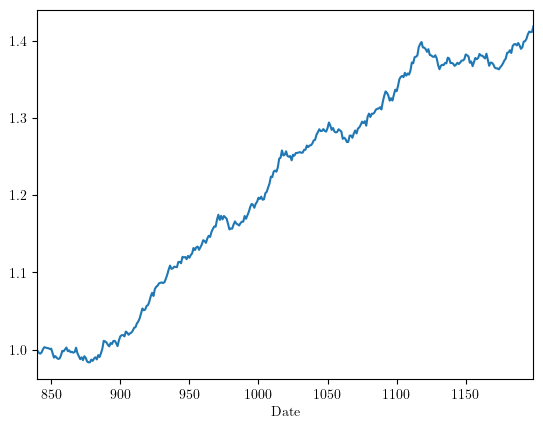

In [356]:
drrpw.portfolio.rets.tri.plot()

In [355]:
(rp_net.portfolio)